In [1]:
import numpy as np
import os
import glob
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## All features for all basins with temporal aggregations with target Emiliani2 VHI

In [4]:
csv_with_aggreg = "./features_with_aggregations.csv"

In [5]:
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

In [6]:
# merge with target values of Emiliani2
csv_target = "./csv/Emiliani2.csv"
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]

target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [7]:
# remove the date column
features_df = all_features.iloc[:,1:]

In [8]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Adda_tg
1: cyclostationary_mean_Dora_tg
2: cyclostationary_mean_Emiliani1_tg
3: cyclostationary_mean_Piemonte_Sud_tg
4: cyclostationary_mean_Piemonte_Nord_tg
5: cyclostationary_mean_Oglio_Iseo_tg
6: cyclostationary_mean_Ticino_tg
7: cyclostationary_mean_Garda_Mincio_tg
8: cyclostationary_mean_Lambro_Olona_tg
9: cyclostationary_mean_Emiliani2_tg
10: cyclostationary_mean_Adda_rr
11: cyclostationary_mean_Dora_rr
12: cyclostationary_mean_Emiliani1_rr
13: cyclostationary_mean_Piemonte_Sud_rr
14: cyclostationary_mean_Piemonte_Nord_rr
15: cyclostationary_mean_Oglio_Iseo_rr
16: cyclostationary_mean_Ticino_rr
17: cyclostationary_mean_Garda_Mincio_rr
18: cyclostationary_mean_Lambro_Olona_rr
19: cyclostationary_mean_Emiliani2_rr
20: cyclostationary_mean_Adda_tg_1w
21: cyclostationary_mean_Adda_tg_4w
22: cyclostationary_mean_Adda_tg_8w
23: cyclostationary_mean_Adda_tg_12w
24: cyclostationary_mean_Adda_tg_16w
25: cyclostationary_mean_Adda_tg_24w
26: cyclostationary_mean_Dora

# Feature Selection and linear regression

### Prepare pickle file for FS algorithm, with only the training set

In [ ]:
# features selection done only on training set
n = 0.6

features_train = features_df.iloc[0:round(len(features_df)*n)]
len(features_train)

589

In [ ]:
target_train = target_df[0:round(len(target_df)*n)]
len(target_train)

589

In [ ]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features_train.values)
scaled_train_target = scaler.fit_transform(target_train.values)

In [ ]:
output = { "X" : scaled_train_features, "Y" : scaled_train_target}

with open("./pickles/targetEmiliani2.pickle", "wb") as f:
    pickle.dump(output, f)

### FS algorithm with different parameters values

#### k = 3

In [ ]:
# Delta: 0.005, 0.01, final number of features: 1, selected features IDs: [0]
# Delta: 0.03 final number of features: 3, selected features IDs: [0, 84, 89]
# Delta: 0.05, 0.1 final number of features: 6, selected features IDs: [0, 84, 89, 93, 110, 120]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 3

#### k = 10

In [ ]:
# Delta: 0.005, 0.01, final number of features: 1, selected features IDs: [9]
# Delta: 0.03 final number of features: 3, selected features IDs: [9, 136, 102]
# Delta: 0.05, 0.1 final number of features: 4, selected features IDs: [9, 136, 102, 110]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 10

#### k = 25

In [ ]:
# Delta: 0.005, 0.01, final number of features: 1, selected features IDs: [93]
# Delta: 0.03, 0.05, 0.1 final number of features: 4, selected features IDs: [93, 68, 131, 110]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 25

#### k = 100

In [ ]:
# Delta: 0.005, final number of features: 1, selected features IDs: [93]
# Delta: 0.01, 0.03, 0.05, 0.1 final number of features: 3, selected features IDs: [93, 92, 8]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 100

## Linear Regression

In [9]:
# used split 80-20 for linear regression train and test

n = 0.8

features_train_regr = features_df.iloc[0:round(len(features_df)*n),:]
target_train_regr = target_df.iloc[0:round(len(target_df)*n),:]

features_test_regr = features_df.iloc[round(len(features_df)*n):]
target_test_regr = target_df.iloc[round(len(target_df)*n):]

scaler_f = StandardScaler()
scaler_t = StandardScaler()

# for training data fit and transform
scaled_train_features_regr = pd.DataFrame(scaler_f.fit_transform(features_train_regr.values), 
                               index=features_train_regr.index, columns=features_train_regr.columns)
scaled_train_target_regr = pd.DataFrame(scaler_t.fit_transform(target_train_regr.values), 
                             index=target_train_regr.index, columns=target_train_regr.columns)


scaled_test_features_regr = pd.DataFrame(scaler_f.transform(features_test_regr.values), 
                                    index=features_test_regr.index, columns=features_test_regr.columns)
scaled_test_target_regr = pd.DataFrame(scaler_t.transform(target_test_regr.values), 
                                    index=target_test_regr.index, columns=target_test_regr.columns)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# tutte le features
X_train_all = scaled_train_features_regr
y_train_regr = scaled_train_target_regr

X_test_all = scaled_test_features_regr
y_test = scaled_test_target_regr

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(X_train_all, y_train_regr)
print("Linear Regression all features: ")
print("R2_train: ", round(reg.score(X_train_all, y_train_regr),3))
#print(mean_squared_error(y_train,reg.predict(X_train_all),squared=False))
print("R2_test: ", round(reg.score(X_test_all, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test_all)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test_all),squared=False),3))
print('\n')

# delta piccolo
X_train = X_train_all.iloc[:,[0, 9, 93]]
X_test = X_test_all.iloc[:,[0, 9, 93]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("R2_train: ", reg.score(X_train, y_train_regr))
print("R2_test: ", reg.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))
print('\n')

# [93, 92, 8, 123, 138, 58, 29]
# delta grande, k piccola
X_train = X_train_all.iloc[:,[93, 68, 131, 110]]
X_test = X_test_all.iloc[:,[93, 68, 131, 110]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("Linear Regression chosen features: ")
print("R2_train: ", round(reg.score(X_train, y_train_regr),3))
print("R2_test: ", round(reg.score(X_test, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test),squared=False),3))
print('\n')

# delta medio, k alta
X_train = X_train_all.iloc[:,[93, 92, 8, 123]]
X_test = X_test_all.iloc[:,[93, 92, 8, 123]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("R2_train: ", reg.score(X_train, y_train_regr))
print("R2_test: ", reg.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))
print('\n')

# delta alto, k alta
X_train = X_train_all.iloc[:,[93, 92, 8]]
X_test = X_test_all.iloc[:,[93, 92, 8]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("R2_train: ", reg.score(X_train, y_train_regr))
print("R2_test: ", reg.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))

Linear Regression all features: 
R2_train:  0.479
R2_test:  -0.122
MAE:  0.83
MSE:  1.064


R2_train:  0.2348964799929556
R2_test:  0.08250123657194541
MSE:  0.9622802699472394


Linear Regression chosen features: 
R2_train:  0.238
R2_test:  0.129
MAE:  0.77
MSE:  0.937


R2_train:  0.24920952635386961
R2_test:  0.11225201631399995
MSE:  0.946550272488765


R2_train:  0.24878991764053537
R2_test:  0.1057239098384295
MSE:  0.9500241541033596


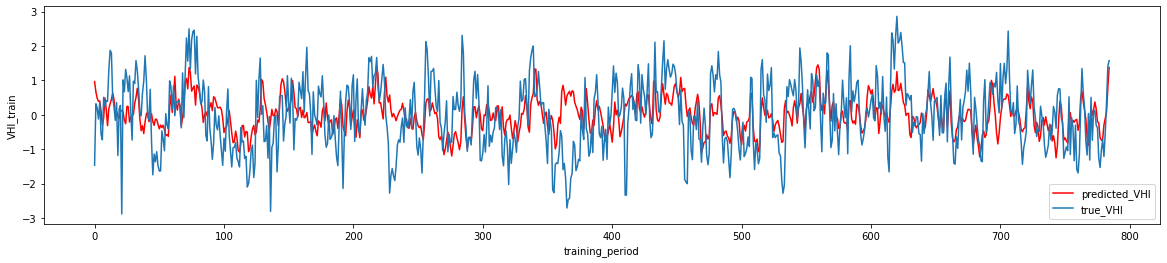

In [12]:
import matplotlib.pyplot as plt

X_train = X_train_all.iloc[:,[93, 68, 131, 110]]
reg = LinearRegression().fit(X_train, y_train_regr)
# plot prediction on train
prediction = reg.predict(X_train)

plt.ylabel("VHI_train")
plt.xlabel("training_period")

plt.plot(prediction, color='red', label="predicted_VHI")
plt.plot(y_train_regr, label="true_VHI")

plt.legend(loc="lower right")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

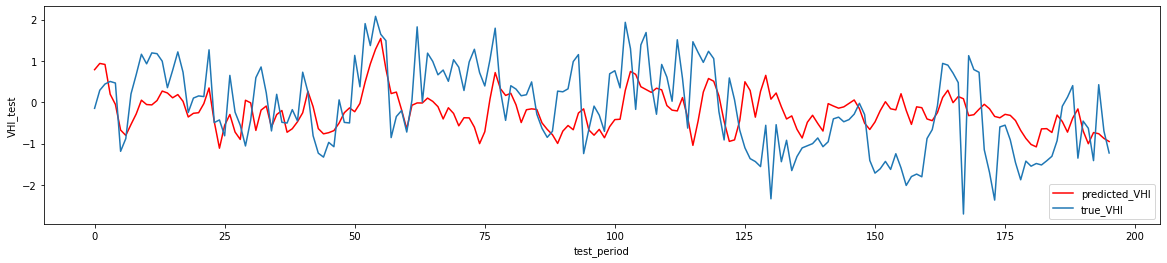

In [ ]:
X_test = X_test_all.iloc[:,[93, 68, 131, 110]]

prediction = reg.predict(X_test)

plt.plot(prediction, color='red', label="predicted_VHI")
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test, label="true_VHI")

plt.ylabel("VHI_test")
plt.xlabel("test_period")

plt.legend(loc="lower right")

plt.rcParams["figure.figsize"] = (15,4)
plt.show()

# Non linear models

## Imports and functions

In [13]:
! pip install hypopt
! pip install tensorflow_addons
from sklearn.ensemble import ExtraTreesRegressor
from hypopt import GridSearch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow_addons.metrics import RSquare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [14]:
def feed_forward():
  # learning rate
  lr = 1e-3

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=4, activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(units = 1))

  metrics = [tf.keras.metrics.MeanAbsoluteError()]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss='mse',
                metrics=metrics)
  
  return model

## train, valid, test split

In [15]:
chosen_features_ids = [93, 68, 131, 110]
chosen_features = features_df.iloc[:,chosen_features_ids]

train_perc = 0.6
valid_perc = 0.2
train_valid_perc = 1 - valid_perc
tot_rows = len(chosen_features)

features_train = chosen_features.iloc[0:round(tot_rows*train_perc),:]
target_train = target_df.iloc[0:round(tot_rows*train_perc),:]

scaler_f = StandardScaler()
scaler_t = StandardScaler()

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
chosen_features = pd.DataFrame(scaler_f.transform(chosen_features[chosen_features.columns]), 
                                    index=chosen_features.index, columns=chosen_features.columns)
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

scaled_train_features = chosen_features.iloc[0:round(tot_rows*train_perc)]
scaled_valid_features = chosen_features.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
scaled_test_features = chosen_features.iloc[round(tot_rows*train_valid_perc):]

scaled_train_target = target_df.iloc[0:round(tot_rows*train_perc)]
scaled_valid_target = target_df.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
scaled_test_target = target_df.iloc[round(tot_rows*train_valid_perc):]

train_valid_features = pd.concat([scaled_train_features,scaled_valid_features]).values
train_valid_target = pd.concat([scaled_train_target,scaled_valid_target]).values

##  ExtraTreeRegression

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [16]:
from sklearn.ensemble import ExtraTreesRegressor
from hypopt import GridSearch

best_rf = ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=158,
                    random_state=0)

# opt = GridSearch(model = extra, param_grid = random_grid)
#opt.fit(scaled_train_features.values, scaled_train_target.values.ravel(), scaled_valid_features.values, 
#        scaled_valid_target.values.ravel())

In [17]:
#best_rf = opt.best_estimator_
best_rf.fit(train_valid_features, train_valid_target.ravel())

ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=158,
                    random_state=0)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(scaled_test_target.values.ravel(), best_rf.predict(scaled_test_features.values))
rf_mse = mean_squared_error(scaled_test_target.values.ravel(), best_rf.predict(scaled_test_features.values))
r2_test = best_rf.score(scaled_test_features.values, scaled_test_target.values.ravel())
r2_train = best_rf.score(train_valid_features, train_valid_target.ravel())
print(" ExtraTreesRegressor")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor
 MAE:  0.744 
 MSE:  0.8 
 R2_test:  0.174 
 R2_train:  0.719


## Feed Forward

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

ffnn_val = feed_forward()

hist_val = ffnn_val.fit(scaled_train_features.values, scaled_train_target.values, shuffle=False, epochs=600, 
                       validation_data=(scaled_valid_features.values, scaled_valid_target.values), verbose = 0#, callbacks=callback
                        )

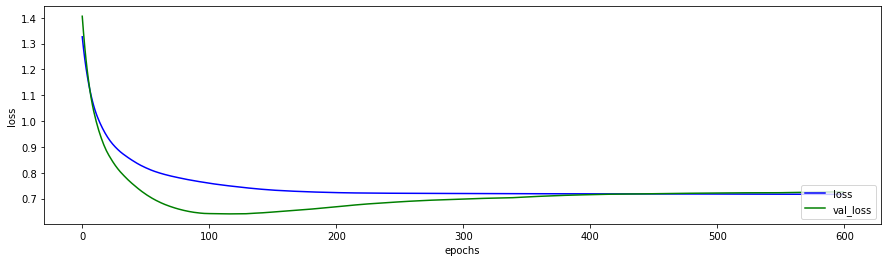

In [ ]:
plt.plot(hist_val.history['loss'], 'b', label = 'loss')
plt.plot(hist_val.history['val_loss'],'g', label = 'val_loss')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend(loc="lower right")

In [19]:
ffnn = feed_forward()
ffnn.fit(train_valid_features, train_valid_target.ravel(), shuffle=False, epochs=100, verbose = 0)

In [20]:
ffnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [21]:
ffnn_MAE = mean_absolute_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))
ffnn_MSE = mean_squared_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))

metric = RSquare()
metric.update_state(scaled_test_target.values, ffnn.predict(scaled_test_features.values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(train_valid_target, ffnn.predict(train_valid_features))
r2_train = metric.result()
r2_train.numpy()

25/25 [==============================] - 0s 1ms/step


0.2295667

In [22]:
print(" FFNN:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

 FFNN:
 MAE:  0.751 
 MSE:  0.841 
 R2_test:  0.132 
 R2_train:  0.23


# Graphs

In [23]:
X_train = X_train_all.iloc[:,chosen_features_ids]
X_test = X_test_all.iloc[:,chosen_features_ids]
reg = LinearRegression().fit(X_train, y_train_regr)

7/7 [==============================] - 0s 4ms/step


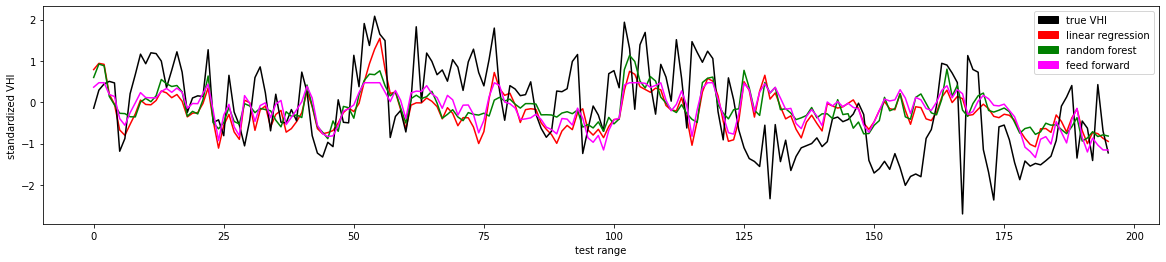

In [24]:
import matplotlib.patches as mpatches

prediction = reg.predict(X_test)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test, color='black')
random_forest = best_rf.predict(scaled_test_features.values)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(scaled_test_features.values)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("test range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])

plt.rcParams["figure.figsize"] = (20,5)
plt.show()

25/25 [==============================] - 0s 4ms/step


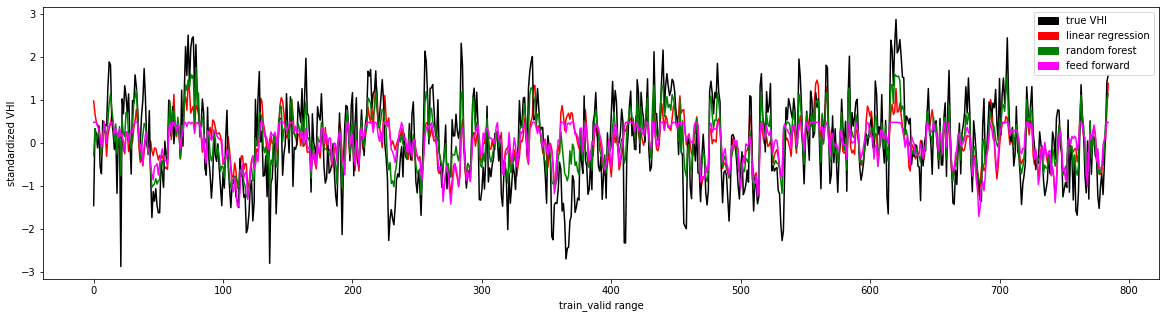

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

prediction = reg.predict(X_train)
plt.plot(prediction, color='red')
y_train_regr.reset_index(drop = True, inplace = True)
plt.plot(y_train_regr, color='black')
random_forest = best_rf.predict(train_valid_features)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(train_valid_features)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("train valid range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])
plt.rcParams["figure.figsize"] = (20,4)
plt.show()

25/25 [==============================] - 0s 2ms/step


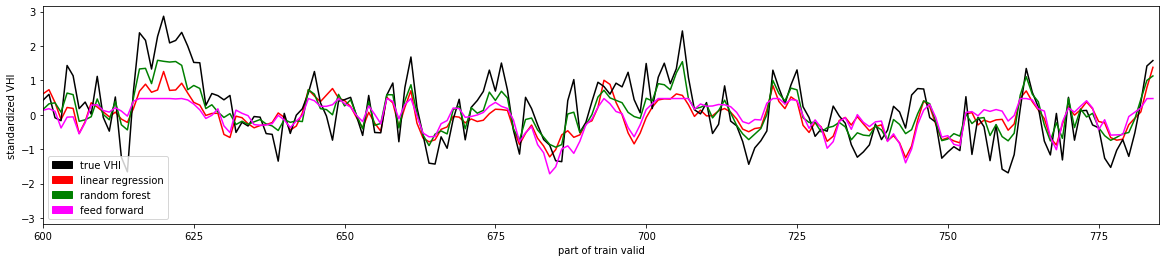

In [31]:
prediction = reg.predict(X_train)
plt.plot(prediction, color='red')
y_train_regr.reset_index(drop = True, inplace = True)
plt.plot(y_train_regr, color='black')
random_forest = best_rf.predict(train_valid_features)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(train_valid_features)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("part of train valid")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])
plt.rcParams["figure.figsize"] = (20,4)
plt.xlim([600, 785])
plt.show()